<a href="https://colab.research.google.com/github/dclunie/ProjectWeek/blob/master/DICOMwebToolComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DICOMweb for pathology

In [ ]:
!pip install dicomweb-client[gcp]
!pip install wsidicom
!pip install dicomslide

In [ ]:
# Authentification via Google Colab
from google.colab import auth
auth.authenticate_user()

## dicomweb_client
- implements QIDO-RS, WADO-RS and STOW-RS endpoints as defined by the DICOMweb standard: see [conformance statement](https://dicomweb-client.readthedocs.io/en/latest/conformance.html)
- provides a DICOMwebClient and a DICOMfileClient

In [ ]:
from dicomweb_client.api import DICOMwebClient
from dicomweb_client.ext.gcp.session_utils import create_session_from_gcp_credentials
from dicomweb_client.ext.gcp.uri import GoogleCloudHealthcareURL

In [ ]:
session = create_session_from_gcp_credentials()

dicom_server_url = GoogleCloudHealthcareURL(
    project_id='idc-external-031',
    location='us-central1',
    dataset_id='projectweek40',
    dicom_store_id='projectweek40-store'
)

dw_client = DICOMwebClient(
    url=str(dicom_server_url),
    session=session
)

In [ ]:
# Example use to search for studies:
all_studies = dw_client.search_for_series()
print(all_studies)

[{'00080020': {'vr': 'DA', 'Value': ['20100520']}, '00080030': {'vr': 'TM', 'Value': ['145936']}, '00080050': {'vr': 'SH', 'Value': ['TCGA-05-4244']}, '00080060': {'vr': 'CS', 'Value': ['SM']}, '00080090': {'vr': 'PN', 'Value': [{'Alphabetic': '^^^^'}]}, '00080201': {'vr': 'SH', 'Value': ['+0000']}, '0008103E': {'vr': 'LO', 'Value': ['Frozen HE TP BS1']}, '00100010': {'vr': 'PN', 'Value': [{'Alphabetic': 'TCGA-05-4244'}]}, '00100020': {'vr': 'LO', 'Value': ['TCGA-05-4244']}, '00100030': {'vr': 'DA'}, '00100040': {'vr': 'CS'}, '0020000D': {'vr': 'UI', 'Value': ['2.25.317753984268209060558780446660059290395']}, '0020000E': {'vr': 'UI', 'Value': ['1.3.6.1.4.1.5962.99.1.1068263875.756580321.1637450836419.2.0']}, '00200010': {'vr': 'SH', 'Value': ['TCGA-05-4244']}}, {'00080020': {'vr': 'DA', 'Value': ['20220603']}, '00080030': {'vr': 'TM', 'Value': ['002016']}, '00080050': {'vr': 'SH', 'Value': ['TCGA-05-4244']}, '00080060': {'vr': 'CS', 'Value': ['SM']}, '00080090': {'vr': 'PN', 'Value': [

##wsidicom
- [Documentation](https://pypi.org/project/wsidicom/) and [Code](https://github.com/imi-bigpicture/wsidicom)
- wsidicom wraps dicomweb_client's `DICOMwebClient` in the class `WsiDicomWebClient`, so access to all functionality of dicomweb_client is still possible.
- An instance of the `WsiDicomWebClient` can be created from scratch providing the DICOM server URL and authentification. Alternatively, a `DICOMwebClient` instance can be used to create a `WsiDicomWebClient`. The entrypoint to all remaining wsidicom functionality is the function [`WsiDicom.open_web()`](https://github.com/imi-bigpicture/wsidicom/blob/bc2edb5b0f01c810b60bae1cd8c236ab1ee446cb/wsidicom/wsidicom.py#L108).
- Code for DICOMweb functionality additional to dicomweb_client's `DICOMwebClient` can be found in [wsidicom_web_client.py](https://github.com/imi-bigpicture/wsidicom/blob/f5c5312cc8159f02867233f07350882c5de68d43/wsidicom/web/wsidicom_web_client.py), [wsidicom_web_image_data.py](https://github.com/imi-bigpicture/wsidicom/blob/f5c5312cc8159f02867233f07350882c5de68d43/wsidicom/web/wsidicom_web_image_data.py) and [wsidicom_web_source.py](https://github.com/imi-bigpicture/wsidicom/blob/f5c5312cc8159f02867233f07350882c5de68d43/wsidicom/web/wsidicom_web_source.py).
- seems to load pixel data into memory and holds them there.


In [ ]:
from wsidicom import WsiDicom, WsiDicomWebClient

In [ ]:
# Set-up wsidicom client from dw_client
wsidicom_client = WsiDicomWebClient(dw_client)

In [ ]:
# Entry point to WsiDicom object
slide = WsiDicom.open_web(wsidicom_client,
                  study_uid='2.25.317753984268209060558780446660059290395',
                  series_uids='1.3.6.1.4.1.5962.99.1.1042652702.25371455.1637425225246.2.0'
                  )

*Snippet from documentation:* **A WSI DICOM pyramid is in wsidicom represented by a hierarchy of objects of different classes**, starting from bottom (Note: apparently similar to openslide):

- `WsiDicomReader`, represents a WSI DICOM file reader, used for accessing WsiDicomFileImageData and WsiDataset.
- `WsiDicomFileImageData`, represents the image data in one or several (in case of concatenation) WSI DICOM files.
- `WsiDataset`, represents the image metadata in one or several (in case of concatenation) WSI DICOM files.
- `WsiInstance`, represents image data and image metadata.
Level, represents a group of instances with the same image size, i.e. of the same level.
- `Pyramid`, represents a group of levels, i.e. the pyrimidal structure.
Pyramids, represents a collection of pyramids, each with different image coordate system or extended depth of field.
- `WsiDicom`, represents a collection of pyramids, labels and overviews.
Labels and overviews are structured similarly to levels, but with somewhat different properties and restrictions. For DICOMWeb the WsiDicomFile* classes are replaced with WsiDicomWeb* classes.

A Source is used to create WsiInstances, either from files (`WsiDicomFileSource`) or DICOMWeb (`WsiDicomWebSource`), and can be used to to Initiate a WsiDicom object. A source is easiest created with the `open()` and `open_web()` helper functions.

## dicomslide
- [Documentation](https://dicomslide.readthedocs.io/en/latest/introduction.html#design), [Code](https://github.com/ImagingDataCommons/dicomslide)
- dicomslide directly leverages dicomweb_client to access DICOM WSI from a file system or via DICOMweb.
- Entrypoint to remaining functionality is `dicomslide.find_slides()`.
- does not load the entire images into memory, but dynamically retrieves only the image frames (tiles) that are needed for a requested image region.
- For 2D color images, dicomslide also exposes an OpenSlide interface (`dicomslide.OpenSlide`), which is intended as an API wrapper around a `dicomslide.Slide` instance and to be used as a drop-in replacement for an `openslide.OpenSlide` instance

In [ ]:
import dicomslide
found_slides = dicomslide.find_slides(dw_client, study_instance_uid='2.25.317753984268209060558780446660059290395')
print(found_slides)

*Snippet from documentation:* The dicomslide Python package contains several data structures that abstract whole slide images. The core data structure of the library is the **`dicomslide.Slide class`**, which represents a **collection of DICOM VL Whole Slide Microscopy Image instances that share the same Container Identifier and Frame of Reference UID, i.e., that were acquired for the same physical class slide and are spatially aligned**. The interface exposed by the dicomslide.Slide class abstracts the organization of tiled images that belong to the slide (`dicomslide.TiledImage`) and the associated total pixel matrices (`dicomslide.TotalPixelMatrix`), which form a multi-resolution image pyramid (`dicomslide.Pyramid`).

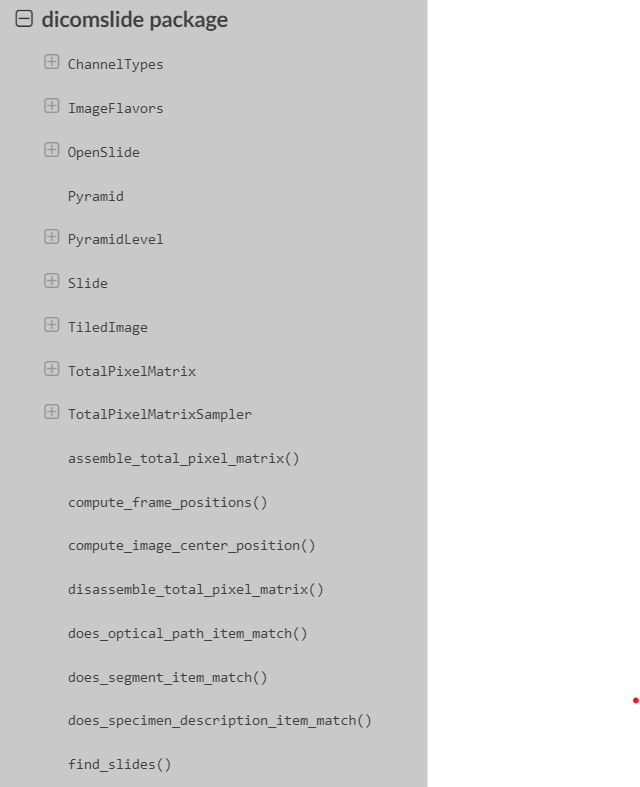

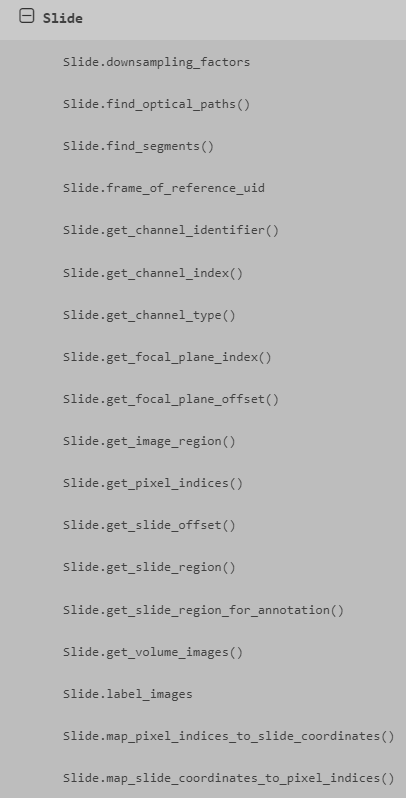